In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

# data loading

In [3]:
df = pd.read_csv("../data/preprocessed/dataset_merged_with_sentiment.csv")
df.set_index('observation_date', inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 831 entries, 1954/7/1 to 2023/9/1
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               831 non-null    object 
 1   FEDFUNDS            831 non-null    float64
 2   Target              830 non-null    float64
 3   Target_category     830 non-null    object 
 4   PCE                 777 non-null    float64
 5   Consumer_Sentiment  765 non-null    float64
 6   Supply_NewHouse     729 non-null    float64
 7   CPI                 831 non-null    float64
 8   ISM PMI             831 non-null    float64
 9   Housing_starts      765 non-null    float64
 10  Unemp_rate          831 non-null    float64
 11  SPX                 831 non-null    float64
 12  10y_try             741 non-null    float64
 13  year_month          214 non-null    object 
 14  content             214 non-null    object 
 15  word_count          214 non-null    float64
 16  S

In [5]:
df.columns

Index(['month', 'FEDFUNDS', 'Target', 'Target_category', 'PCE',
       'Consumer_Sentiment', 'Supply_NewHouse', 'CPI', 'ISM PMI',
       'Housing_starts', 'Unemp_rate', 'SPX', '10y_try', 'year_month',
       'content', 'word_count', 'Sentiment', 'Sentiment_score',
       'sentiment_score_LM', 'NPositiveWords', 'NNegativeWords', 'Poswords',
       'Negwords'],
      dtype='object')

In [6]:
target = ['Target_category']
num_features = ['PCE','Consumer_Sentiment','Supply_NewHouse','CPI','ISM PMI','Housing_starts','Unemp_rate','SPX','10y_try','sentiment_score_LM']
cat_features = ['Sentiment']
df2 = df[target + num_features+cat_features]
df2 = df2.ffill() # use last value to fill nan
df2

,Target_category,PCE,Consumer_Sentiment,Supply_NewHouse,CPI,ISM PMI,Housing_starts,Unemp_rate,SPX,10y_try,sentiment_score_LM,Sentiment
observation_date,,,,,,,,,,,,
1954/7/1,NaN,NaN,NaN,NaN,26.860,63.8,NaN,5.8,30.88,NaN,NaN,NaN
1954/8/1,increase,NaN,NaN,NaN,26.850,56.6,NaN,6.0,29.83,NaN,NaN,NaN
1954/9/1,decrease,NaN,NaN,NaN,26.810,62.2,NaN,6.1,32.31,NaN,NaN,NaN
1954/10/1,decrease,NaN,NaN,NaN,26.720,66.7,NaN,5.7,31.68,NaN,NaN,NaN
1954/11/1,decrease,NaN,NaN,NaN,26.780,66.0,NaN,5.3,34.24,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023/5/1,increase,118.984,97.21225,7.2,303.294,46.9,1496.0,3.7,4179.83,3.646,-0.591716,positive
2023/6/1,increase,119.189,97.50814,7.5,303.841,46.0,1441.0,3.6,4450.38,3.840,-0.564972,positive
2023/7/1,increase,119.449,97.87399,7.0,304.348,46.4,1443.0,3.5,4588.96,3.962,-0.584795,positive


In [7]:
# transform sentiment
sentiment_mapping = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}
target_mapping = {
    'increase': 1,
    'decrease': -1,
    'hold': 0
}
df2 = df2.copy()
df2['Sentiment'] = df2['Sentiment'].map(sentiment_mapping)
df2['Target_category'] = df2['Target_category'].map(target_mapping)

In [8]:
df2

,Target_category,PCE,Consumer_Sentiment,Supply_NewHouse,CPI,ISM PMI,Housing_starts,Unemp_rate,SPX,10y_try,sentiment_score_LM,Sentiment
observation_date,,,,,,,,,,,,
1954/7/1,NaN,NaN,NaN,NaN,26.860,63.8,NaN,5.8,30.88,NaN,NaN,NaN
1954/8/1,1.0,NaN,NaN,NaN,26.850,56.6,NaN,6.0,29.83,NaN,NaN,NaN
1954/9/1,-1.0,NaN,NaN,NaN,26.810,62.2,NaN,6.1,32.31,NaN,NaN,NaN
1954/10/1,-1.0,NaN,NaN,NaN,26.720,66.7,NaN,5.7,31.68,NaN,NaN,NaN
1954/11/1,-1.0,NaN,NaN,NaN,26.780,66.0,NaN,5.3,34.24,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023/5/1,1.0,118.984,97.21225,7.2,303.294,46.9,1496.0,3.7,4179.83,3.646,-0.591716,1.0
2023/6/1,1.0,119.189,97.50814,7.5,303.841,46.0,1441.0,3.6,4450.38,3.840,-0.564972,1.0
2023/7/1,1.0,119.449,97.87399,7.0,304.348,46.4,1443.0,3.5,4588.96,3.962,-0.584795,1.0


In [9]:
# shift data 
def shift_data(data, n):
    data_shift = data.shift(n)
    colnames = [fea + '_s' + str(n) for fea in data.columns]
    data_shift.columns = colnames
    return data_shift

# percent change for numerical feature
def pctchg_data(data):
    data_pctchg = data.pct_change()
    colnames = [fea + '_pctchg' for fea in data.columns]
    data_pctchg.columns = colnames
    return data_pctchg

df_shift1 = shift_data(df2[num_features+cat_features], 1)
df_shift2 = shift_data(df2[num_features+cat_features], 2)
df_shift3 = shift_data(df2[num_features+cat_features], 3)
df_pctchg = pctchg_data(df2[num_features])
df_pctchg_shift1 = shift_data(df_pctchg, 1)
df_pctchg_shift2 = shift_data(df_pctchg, 2)
df_pctchg_shift3 = shift_data(df_pctchg, 3)

df_all = pd.concat([df2,
           df_shift1,
           df_shift2,
           df_shift3,
           df_pctchg,
           df_pctchg_shift1,
           df_pctchg_shift2,
           df_pctchg_shift3], axis = 1)

In [10]:
df_all[num_features+cat_features].describe()

,PCE,Consumer_Sentiment,Supply_NewHouse,CPI,ISM PMI,Housing_starts,Unemp_rate,SPX,10y_try,sentiment_score_LM,Sentiment
count,777.000000,765.000000,729.000000,831.000000,831.000000,765.000000,831.000000,831.000000,741.000000,356.000000,356.000000
mean,58.946678,100.000000,6.093278,128.531264,55.724669,1370.415686,5.857762,821.662900,5.867625,-0.373729,0.485955
std,31.074711,1.481537,1.656902,82.608377,7.944666,380.483066,1.666064,1042.433709,2.995255,2.352928,0.588457
min,15.501000,96.134240,3.300000,26.710000,23.200000,513.000000,3.400000,29.830000,0.529000,-10.344828,-1.000000
25%,26.441000,98.878640,4.900000,40.950000,51.100000,1118.000000,4.600000,94.790000,3.839000,-1.513306,0.000000
50%,62.307000,100.488800,5.800000,121.600000,56.400000,1351.000000,5.600000,306.050000,5.622000,0.000000,1.000000
75%,85.988000,101.064900,6.900000,201.550000,61.300000,1651.000000,6.900000,1251.390000,7.642000,1.320307,1.000000
max,119.911000,102.879900,12.200000,307.481000,74.800000,2419.000000,14.700000,4766.180000,15.842000,4.347826,1.000000


In [11]:
df_all.index = pd.to_datetime(df_all.index)

In [12]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 831 entries, 1954-07-01 to 2023-09-01
Data columns (total 85 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Target_category               830 non-null    float64
 1   PCE                           777 non-null    float64
 2   Consumer_Sentiment            765 non-null    float64
 3   Supply_NewHouse               729 non-null    float64
 4   CPI                           831 non-null    float64
 5   ISM PMI                       831 non-null    float64
 6   Housing_starts                765 non-null    float64
 7   Unemp_rate                    831 non-null    float64
 8   SPX                           831 non-null    float64
 9   10y_try                       741 non-null    float64
 10  sentiment_score_LM            356 non-null    float64
 11  Sentiment                     356 non-null    float64
 12  PCE_s1                        776 non-null   

In [13]:
#look at only data after 1963, to avoid missing data
#look at only data after 1994, to avoid missing data
df_all2 = df_all[df_all.index>= '1994-01-01']
df_all2 = df_all2.bfill().ffill()
df_all2 = df_all2.replace(np.Inf,0).replace(-np.Inf, 0)

# feature selectioin

In [14]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_all2.drop(target, axis=1)  
y = df_all2[target]  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.06)
lasso.fit(X_scaled, y)

selected_features = X.columns[(lasso.coef_ != 0)]

print("Selected Features:", selected_features)
print("length of Selected Features:", len(selected_features))


Selected Features: Index(['ISM PMI', 'Unemp_rate', 'sentiment_score_LM', 'Sentiment',
       'sentiment_score_LM_s1', 'Sentiment_s1', 'Housing_starts_s3',
       'sentiment_score_LM_s3', 'PCE_pctchg', 'CPI_pctchg',
       'Housing_starts_pctchg', 'SPX_pctchg', 'Consumer_Sentiment_pctchg_s1',
       'ISM PMI_pctchg_s1', '10y_try_pctchg_s1', '10y_try_pctchg_s2'],
      dtype='object')
length of Selected Features: 16


In [96]:
# selected_features = ['Sentiment_s1','ISM PMI','Unemp_rate','sentiment_score_LM','Housing_starts_s3']

In [15]:
# check the proporation of each label
df_all2[target].value_counts()/len(df_all2)

Target_category
 1.0               0.487395
-1.0               0.333333
 0.0               0.179272
Name: count, dtype: float64

# Make Train and Test sets

In [16]:
# Assign values to the X and y variables:
X = df_all2[selected_features]
y = df_all2[target]


In [103]:
df_all2.to_csv('../data/preprocessed/df_train_1994.csv')

In [28]:

X_train = X.iloc[:280]
X_test = X.iloc[280:]
y_train = y.iloc[:280]
y_test = y.iloc[280:]

# transform the dataset
# oversample = SMOTE(k_neighbors=4)
# X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
# check the proporation of each label
# print(y_train_os.value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
rf_model = RandomForestClassifier(
        class_weight='balanced'
    )
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)


/Users/hanyan/Desktop/NYU/7773 Machine Learning/ML_project/fomc/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [32]:
accuracy_score(y_pred, y_test)

0.4935064935064935

# model

In [33]:
# define train window
start_train = df_all2.index.min()
end_train = start_train + pd.DateOffset(months=200)  # 初始训练窗口大小，例如6个月
end_test = df_all2.index.max()

predictions = []
true_values = []

X = df_all2[selected_features]
y = df_all2[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

while end_train <= end_test:

    train_mask = (df_all2.index < end_train)
    test_mask = (df_all2.index >= end_train) & (df_all2.index < end_train + pd.DateOffset(months=1))

    X_train, y_train = X_scaled[train_mask], y[train_mask].values.ravel()
    X_test, y_test = X_scaled[test_mask], y[test_mask].values.ravel()

    rf_model = RandomForestClassifier(
        class_weight='balanced'
    )
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    predictions.extend(y_pred)
    true_values.extend(y_test)

    # increase window size by 1 month
    end_train += pd.DateOffset(months=1)

In [34]:
accuracy = accuracy_score(true_values, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.47


In [35]:
y.value_counts() / len(y)

Target_category
 1.0               0.487395
-1.0               0.333333
 0.0               0.179272
Name: count, dtype: float64

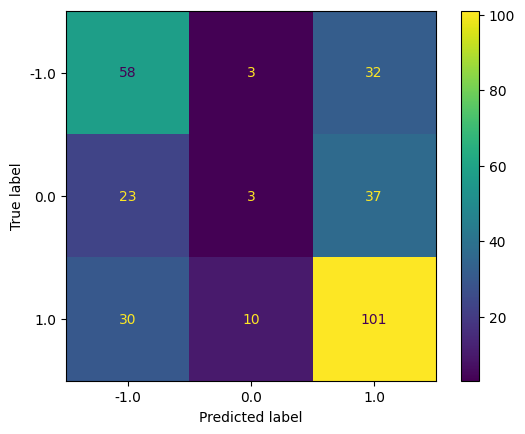

In [81]:
ax = ConfusionMatrixDisplay.from_predictions(true_values, predictions)

In [722]:
from sklearn.preprocessing import StandardScaler
# Initialize SimpleImputer with strategy
#imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
# Fit the imputer on your data
#imputer.fit(X_train)
# Transform your data by filling missing values
X_train = scaler.fit_transform(X_train)

# Initialize SimpleImputer with strategy
#imputer2 = SimpleImputer(strategy='mean')
scaler = StandardScaler()
# Fit the imputer on your data
#imputer2.fit(X_test)
# Transform your data by filling missing values
X_test = scaler.fit_transform(X_test)

In [723]:
# Initialize SimpleImputer with strategy
#imputer2 = SimpleImputer(strategy='mean')
scaler = StandardScaler()
# Fit the imputer on your data
#imputer2.fit(X_test)
# Transform your data by filling missing values
X_test = scaler.fit_transform(X_test)

# Oversampling 

In [27]:
# transform the dataset
oversample = SMOTE(k_neighbors=4)
X_os, y_os = oversample.fit_resample(X, y)

In [704]:
type(y_test)

pandas.core.series.Series

In [705]:
print("Decrease count:" + str(np.count_nonzero(y_test == 0)))
print("Increase count:" + str(np.count_nonzero(y_test == 2)))
print("Hold count:" + str(np.count_nonzero(y_test == 1)))

Decrease count:28
Increase count:28
Hold count:28


In [726]:
print("Decrease count:" + str(np.count_nonzero(y_train == 0)))
print("Increase count:" + str(np.count_nonzero(y_train == 2)))
print("Hold count:" + str(np.count_nonzero(y_train == 1)))

Decrease count:174
Increase count:174
Hold count:174


## Random Forest Model

In [707]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [727]:

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [728]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [717]:
X_test.iloc[:10]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [729]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
#cm = confusion_matrix(y_test, y_pred)

#ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [730]:
y_pred

array([1])

In [713]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print(scores)
    return scores
 

In [731]:
scores = evaluate_model(X_train, y_train, best_rf)
# summarize performance
print('Train Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

[0.74285714 0.79047619 0.67307692 0.76923077 0.70192308 0.67619048
 0.73333333 0.77884615 0.75961538 0.74038462 0.84761905 0.77142857
 0.71153846 0.75961538 0.77884615]
Train Mean Accuracy: 0.749 (0.044)


In [732]:

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Test Accuracy: 1.0


In [573]:
# Create a series containing feature importances from the model and feature names from the training data
best_rf.feature_importances_

array([0.10901246, 0.06120613, 0.05139496, 0.11243407, 0.07018842,
       0.06136108, 0.04160566, 0.0742769 , 0.07332854, 0.03111211,
       0.05897358, 0.03312694, 0.03120372, 0.02846912, 0.03284539,
       0.04873892, 0.03317437, 0.04754764])

In [211]:
## Base Model
model = RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)

In [207]:
scores = evaluate_model(X_train, y_train, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

[0.85207101 0.79881657 0.82248521 0.85714286 0.79166667 0.85207101
 0.83431953 0.78698225 0.79166667 0.85119048 0.81065089 0.79881657
 0.81065089 0.82142857 0.8452381 ]
Mean Accuracy: 0.822 (0.024)


In [212]:
model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [574]:
importances = best_rf.feature_importances_

In [579]:
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

In [580]:
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE",ascending=False).head(20)

,IMPORTANCE
VARIABLE,
CPI_s1,0.112434
PCE_s1,0.109012
SPX_s1,0.074277
10y_try_s1,0.073329
ISM PMI_s1,0.070188
Housing_starts_s1,0.061361
Consumer_Sentiment_s1,0.061206
Consumer_Sentiment_pctchg_s1,0.058974
Supply_NewHouse_s1,0.051395


In [ ]:
## Plot
#fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig= plt.figure(figsize=(18, 16))
#fig.suptitle("Features Importance", fontsize=10)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False).grid(axis="x")
ax[0].set(ylabel="")
#ax[1].title.set_text('cumulative')
#dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
#                                 legend=False, ax=ax[1])
#ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
#          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [484]:
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [485]:
## Accuray e AUC
accuracy = accuracy_score(y_test, predicted)
#auc = roc_auc_score(y_test, predicted_prob, multi_class='ovr')
print("Accuracy (overall correct predictions):",  round(accuracy,2))
#print("Auc:", round(auc,2))
    

ValueError: Found input variables with inconsistent numbers of samples: [348, 288]

In [73]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [74]:
cm

array([[52, 19, 45],
       [28, 71, 17],
       [26, 30, 60]], dtype=int64)

In [75]:
dtree_model.score(X_test, y_test)

0.5258620689655172

# XG Boost

In [470]:
from xgboost import  XGBClassifier

In [457]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [471]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
  'max_depth':[4,5,6],
 'min_child_weight':[4,5,6],
  'min_child_weight':[6,8,10,12],
  'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [474]:
from sklearn.model_selection import GridSearchCV
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [468]:
model = XGBClassifier.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

AttributeError: type object 'XGBClassifier' has no attribute 'train'

In [467]:
cv_results = XGBClassifier.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

AttributeError: type object 'XGBClassifier' has no attribute 'cv'

In [450]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [451]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 40.80%


# SVN

In [76]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

In [77]:
accuracy

0.47701149425287354

# Logistic Regression

In [78]:
modellog = LogisticRegression(random_state=RANDOM_SEED)
modellog = modellog.fit(X_train, y_train)

C:\Users\joohi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
predicted_prob_log = model.predict_proba(X_test)[:,1]
predicted_log = model.predict(X_test)

In [80]:
## Accuray e AUC
accuracy = accuracy_score(y_test, predicted_log)
#auc = roc_auc_score(y_test, predicted_prob_log)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
#print("Auc:", round(auc,2))
    
## Precision e Recall
#recall = recall_score(y_test, predicted_log)
#precision = precision_score(y_test, predicted_log)
#print("Recall (all 1s predicted right):", round(recall,2))
#print("Precision (confidence when predicting a 1):", round(precision,2))
#print("Detail:")
#print(classification_report(y_test, predicted_log, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.62


# KNN

In [81]:
# Use the KNN classifier to fit data:
classifierKNN = KNeighborsClassifier(n_neighbors=5)
classifierKNN.fit(X_train, y_train) 
# Predict y data with classifier: 
y_predictKNN = classifierKNN.predict(X_test)

## Accuray  AUC
accuracy = accuracy_score(y_test, y_predictKNN)

print("Accuracy (overall correct predictions):",  round(accuracy,2))
#print("Auc:", round(auc,2))

# Print results: 
print(confusion_matrix(y_test, y_predictKNN))
print(classification_report(y_test, y_predictKNN)) 

Accuracy (overall correct predictions): 0.62
[[67 19 30]
 [27 70 19]
 [29  8 79]]
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       116
           1       0.72      0.60      0.66       116
           2       0.62      0.68      0.65       116

    accuracy                           0.62       348
   macro avg       0.63      0.62      0.62       348
weighted avg       0.63      0.62      0.62       348



# GaussianNB

In [82]:
# Initialize classifier:
gnb = GaussianNB()
# Train the classifier:
modelGNB = gnb.fit(X_train, y_train) 
# Make predictions with the classifier:
predictive_labels = gnb.predict(X_test)
#print(predictive_labels)
# Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predictive_labels))

0.5201149425287356
